<div class="alert alert-block alert-success">
<b>Implementing regularised logistic regression using diffprivlib:  </b>
    Differential privacy is achieved relative to the maximum norm
    of the data, as determined by `data_norm`, by the :class:`.Vector` mechanism, which adds a Laplace-distributed random vector to the objective.
<b> The technique we will cover in this section will add 
noise, to satisfy privacy, by sometimes returning a false value. It will, however, 
always return a value that is part of the dataset and not a value outside of the data 
universe on which the EM is implemented. This helps improve privacy and also 
eliminates the chances of having invalid values in the dataset.<b>
</div>

<div class="alert alert-block alert-info">
Example with raw loan dataset
</div>

In [1]:
#pip install diffprivlib

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info">
Importing and cleaning data
</div>

In [100]:
df = pd.read_excel("RAIdata.xlsx")
df.head()

,Unnamed: 0,Age,AppliedAmount,DebtToIncome,ExpectedLoss,LiabilitiesTotal,FreeCash,IncomeFromChildSupport,IncomeFromFamilyAllowance,IncomeFromLeavePay,...,VerificationType_2.0,VerificationType_3.0,VerificationType_4.0,WorkExperience_10To15Years,WorkExperience_15To25Years,WorkExperience_2To5Years,WorkExperience_5To10Years,WorkExperience_LessThan2Years,WorkExperience_MoreThan25Years,Young
0,0,54,8505.0,0.0,0.118622,87.82,0.0,0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,52,2230.0,0.0,0.059200,309.23,0.0,0,0.0,0,...,0,0,0,0,0,1,0,0,0,0
2,2,28,530.0,0.0,0.048764,143.58,0.0,0,0.0,0,...,0,0,0,0,0,1,0,0,0,1
3,3,40,1380.0,0.0,0.071894,70.65,0.0,0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
4,4,31,530.0,0.0,0.043700,719.42,0.0,0,0.0,0,...,0,0,1,0,0,0,0,1,0,1


In [234]:
list(df.columns)

['Age',
 'AppliedAmount',
 'DebtToIncome',
 'ExpectedLoss',
 'LiabilitiesTotal',
 'FreeCash',
 'Interest',
 'LossGivenDefault',
 'MonthlyPayment',
 'ProbabilityOfDefault',
 'Income_all_Total',
 'Default']

In [101]:
#find categorical variables
cols = df.columns
num_cols = df._get_numeric_data().columns
list(set(cols) - set(num_cols))

[]

<div class="alert alert-block alert-success">
<b>Inference:</b>
    Dataset does not have categorical data
</div>

In [102]:
# desplay column names
my_list = df.columns.values.tolist()
my_list

['Unnamed: 0',
 'Age',
 'AppliedAmount',
 'DebtToIncome',
 'ExpectedLoss',
 'LiabilitiesTotal',
 'FreeCash',
 'IncomeFromChildSupport',
 'IncomeFromFamilyAllowance',
 'IncomeFromLeavePay',
 'IncomeFromPension',
 'IncomeFromPrincipalEmployer',
 'IncomeFromSocialWelfare',
 'IncomeOther',
 'IncomeTotal',
 'Interest',
 'LoanDuration',
 'LossGivenDefault',
 'MonthlyPayment',
 'ProbabilityOfDefault',
 'NrOfDependantslessthan3',
 'WrExLess10',
 'WrExLess5',
 'Tenant',
 'Default',
 'Country_EE',
 'Country_ES',
 'Country_FI',
 'Country_SK',
 'CreditScoreEeMini_0.0',
 'CreditScoreEeMini_600.0',
 'CreditScoreEeMini_700.0',
 'CreditScoreEeMini_800.0',
 'CreditScoreEeMini_900.0',
 'CreditScoreEeMini_1000.0',
 'CreditScoreEsEquifaxRisk_A',
 'CreditScoreEsEquifaxRisk_AA',
 'CreditScoreEsEquifaxRisk_AAA',
 'CreditScoreEsEquifaxRisk_B',
 'CreditScoreEsEquifaxRisk_C',
 'CreditScoreEsEquifaxRisk_D',
 'CreditScoreEsMicroL_M1',
 'CreditScoreEsMicroL_M2',
 'CreditScoreEsMicroL_M3',
 'CreditScoreEsMicroL_M4'

In [103]:
df.describe(include='all')

,Unnamed: 0,Age,AppliedAmount,DebtToIncome,ExpectedLoss,LiabilitiesTotal,FreeCash,IncomeFromChildSupport,IncomeFromFamilyAllowance,IncomeFromLeavePay,...,VerificationType_2.0,VerificationType_3.0,VerificationType_4.0,WorkExperience_10To15Years,WorkExperience_15To25Years,WorkExperience_2To5Years,WorkExperience_5To10Years,WorkExperience_LessThan2Years,WorkExperience_MoreThan25Years,Young
count,61321.000000,61321.000000,61321.000000,61276.000000,58691.000000,61321.000000,61276.000000,61321.00000,61321.000000,61321.000000,...,61321.000000,61321.000000,61321.000000,61321.000000,61321.000000,61321.000000,61321.000000,61321.000000,61321.000000,61321.000000
mean,30660.000000,38.872409,2369.080129,10.027771,0.091724,421.646016,123.183069,3.41697,7.348459,5.791181,...,0.027381,0.069438,0.432674,0.064562,0.071998,0.298038,0.304969,0.179498,0.080935,0.559449
std,17701.992265,11.922168,2343.365627,17.394999,0.063248,880.433234,427.868227,32.78747,40.140964,68.240263,...,0.163191,0.254199,0.495451,0.245753,0.258487,0.457400,0.460398,0.383772,0.272737,0.496457
min,0.000000,0.000000,31.955800,0.000000,0.000000,0.000000,-2332.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15330.000000,29.000000,530.000000,0.000000,0.044300,123.200000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30660.000000,37.000000,1590.000000,0.000000,0.079900,324.490000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,45990.000000,47.000000,3185.000000,16.380000,0.125028,562.000000,124.087500,0.00000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,61320.000000,77.000000,10630.000000,198.020000,0.609245,172510.000000,82063.820000,2500.00000,2006.000000,2451.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [106]:
num_cols = list(df.select_dtypes(include='float'))
num_cols

['AppliedAmount',
 'DebtToIncome',
 'ExpectedLoss',
 'LiabilitiesTotal',
 'FreeCash',
 'IncomeFromFamilyAllowance',
 'IncomeFromPrincipalEmployer',
 'IncomeOther',
 'IncomeTotal',
 'Interest',
 'LossGivenDefault',
 'MonthlyPayment',
 'ProbabilityOfDefault',
 'Income_all_Total']

In [107]:
# sum Incomes into IncomeTotal
income_cols = ['IncomeFromChildSupport',
                 'IncomeFromFamilyAllowance',
                 'IncomeFromLeavePay',
                 'IncomeFromPension',
                 'IncomeFromPrincipalEmployer',
                 'IncomeFromSocialWelfare',
                 'IncomeOther',
                 'IncomeTotal']
df['Income_all_Total']= df[income_cols].sum(axis=1)

In [108]:
df['Income_all_Total'].describe()

count     61321.000000
mean       2173.505080
std        5034.333118
min           0.000000
25%         838.000000
50%        1214.000000
75%        1900.000000
max      266000.000000
Name: Income_all_Total, dtype: float64

In [13]:
# cols_to_drop = ['Unnamed: 0',
#                 'WrExLess10',
#                 'Country_EE',
#                 'Country_ES',
#                 'Country_FI',
#                 'Country_SK',
#                 'CreditScoreEeMini_0.0',
#                  'CreditScoreEeMini_600.0',
#                  'CreditScoreEeMini_700.0',
#                  'CreditScoreEeMini_800.0',
#                  'CreditScoreEeMini_900.0',
#                  'CreditScoreEeMini_1000.0',
#                  'CreditScoreEsEquifaxRisk_A',
#                  'CreditScoreEsEquifaxRisk_AA',
#                  'CreditScoreEsEquifaxRisk_AAA',
#                  'CreditScoreEsEquifaxRisk_B',
#                  'CreditScoreEsEquifaxRisk_C',
#                  'CreditScoreEsEquifaxRisk_D',
#                  'CreditScoreEsMicroL_M1',
#                  'CreditScoreEsMicroL_M2',
#                  'CreditScoreEsMicroL_M3',
#                  'CreditScoreEsMicroL_M4',
#                  'CreditScoreEsMicroL_M5',
#                  'CreditScoreEsMicroL_M6',
#                  'CreditScoreEsMicroL_M7',
#                  'CreditScoreEsMicroL_M8',
#                  'CreditScoreEsMicroL_M9',
#                  'CreditScoreEsMicroL_M10',
#                  'CreditScoreFiAsiakasTietoRiskGrade_RL0',
#                  'CreditScoreFiAsiakasTietoRiskGrade_RL1',
#                  'CreditScoreFiAsiakasTietoRiskGrade_RL2',
#                  'CreditScoreFiAsiakasTietoRiskGrade_RL3',
#                  'CreditScoreFiAsiakasTietoRiskGrade_RL4',
#                  'CreditScoreFiAsiakasTietoRiskGrade_RL5',
#                  'MonthlyPaymentDay_1',
#                  'MonthlyPaymentDay_2',
#                  'MonthlyPaymentDay_3',
#                  'MonthlyPaymentDay_4',
#                  'MonthlyPaymentDay_5',
#                  'MonthlyPaymentDay_6',
#                  'MonthlyPaymentDay_7',
#                  'MonthlyPaymentDay_8',
#                  'MonthlyPaymentDay_9',
#                  'MonthlyPaymentDay_10',
#                  'MonthlyPaymentDay_11',
#                  'MonthlyPaymentDay_12',
#                  'MonthlyPaymentDay_13',
#                  'MonthlyPaymentDay_14',
#                  'MonthlyPaymentDay_15',
#                  'MonthlyPaymentDay_16',
#                  'MonthlyPaymentDay_17',
#                  'MonthlyPaymentDay_18',
#                  'MonthlyPaymentDay_19',
#                  'MonthlyPaymentDay_20',
#                  'MonthlyPaymentDay_21',
#                  'MonthlyPaymentDay_22',
#                  'MonthlyPaymentDay_23',
#                  'MonthlyPaymentDay_24',
#                  'MonthlyPaymentDay_25',
#                  'MonthlyPaymentDay_26',
#                  'MonthlyPaymentDay_27',
#                  'MonthlyPaymentDay_28',
#                  'NrOfDependants_4',
#                  'NrOfDependants_5',
#                  'NrOfDependants_6',
#                  'NrOfDependants_7',
#                  'NrOfDependants_8',
#                  'NrOfDependants_9',
#                  'NrOfDependants_10Plus',
#                  'Rating_A',
#                  'Rating_AA',
#                  'Rating_B',
#                  'Rating_C',
#                  'Rating_D',
#                  'Rating_E',
#                  'Rating_F',
#                  'Rating_HR',
#                  'UseOfLoan_110',
#                  'VerificationType_1.0',
#                  'VerificationType_2.0',
#                  'VerificationType_3.0',
#                  'VerificationType_4.0', 
#                  'IncomeFromChildSupport',
#                  'IncomeFromFamilyAllowance',
#                  'IncomeFromLeavePay',
#                  'IncomeFromPension',
#                  'IncomeFromPrincipalEmployer',
#                  'IncomeFromSocialWelfare',
#                  'IncomeOther',
#                  'IncomeTotal',
#                  'LanguageCode_1',
#                  'LanguageCode_2',
#                  'LanguageCode_3',
#                  'LanguageCode_4',
#                  'LanguageCode_5',
#                  'LanguageCode_6',
#                  'LanguageCode_7',
#                  'LanguageCode_9',
#                  'LanguageCode_10',
#                  'LanguageCode_13',
#                  'LanguageCode_15',
#                  'LanguageCode_21',
#                  'LanguageCode_22',
#                'UseOfLoan_0',
#  'UseOfLoan_1',
#  'UseOfLoan_2',
#  'UseOfLoan_3',
#  'UseOfLoan_4',
#  'UseOfLoan_5',
#  'UseOfLoan_6',
#  'UseOfLoan_7',
#  'UseOfLoan_8',
#  'UseOfLoan_101',
#  'UseOfLoan_102',
#  'UseOfLoan_104',
#  'UseOfLoan_106',
#  'UseOfLoan_107',
#  'UseOfLoan_108']

In [14]:
#df = df[df.columns.drop(cols_to_drop)]

In [109]:
df = df[['Age', 
              'AppliedAmount',
              'DebtToIncome',
              'ExpectedLoss',
              'LiabilitiesTotal',
              'FreeCash',
              'Interest',
              'LossGivenDefault',
              'MonthlyPayment',
              'ProbabilityOfDefault',
              'Income_all_Total',
                'Default']]

In [110]:
df.head()

,Age,AppliedAmount,DebtToIncome,ExpectedLoss,LiabilitiesTotal,FreeCash,Interest,LossGivenDefault,MonthlyPayment,ProbabilityOfDefault,Income_all_Total,Default
0,54,8505.0,0.0,0.118622,87.82,0.0,30.22,0.638705,390.43,0.216012,900.0,0
1,52,2230.0,0.0,0.059200,309.23,0.0,17.53,0.429112,63.49,0.171474,700.0,0
2,28,530.0,0.0,0.048764,143.58,0.0,15.13,0.524213,14.42,0.254991,765.0,0
3,40,1380.0,0.0,0.071894,70.65,0.0,19.10,0.471205,40.47,0.176218,1300.0,0
4,31,530.0,0.0,0.043700,719.42,0.0,14.32,0.521446,14.19,0.131077,950.0,0


In [235]:
df.isnull().sum().sum()

0

In [113]:
df.isnull().sum()


Age                        0
AppliedAmount              0
DebtToIncome              45
ExpectedLoss            2630
LiabilitiesTotal           0
FreeCash                  45
Interest                   0
LossGivenDefault        2630
MonthlyPayment          5968
ProbabilityOfDefault    2630
Income_all_Total           0
Default                    0
dtype: int64

In [114]:
#Let's sheck what features have the naull values and sort it in descending order
obj = df.isnull().sum().sort_values(ascending=False)
for key,value in obj.iteritems():
    print(key,",",value)

MonthlyPayment , 5968
ExpectedLoss , 2630
LossGivenDefault , 2630
ProbabilityOfDefault , 2630
DebtToIncome , 45
FreeCash , 45
Age , 0
AppliedAmount , 0
LiabilitiesTotal , 0
Interest , 0
Income_all_Total , 0
Default , 0


In [ ]:
# filling missing values with average 
#df = df.fillna(df.median())

In [115]:
# dropping missing values
df = df.dropna().reset_index(drop=True)

In [116]:
df.to_csv('Cleaned_RAI.csv', index = False)

In [117]:
df.Default.value_counts(normalize=True)

0    0.762127
1    0.237873
Name: Default, dtype: float64

In [118]:
df.isnull().sum().sort_values(ascending=False)

Age                     0
AppliedAmount           0
DebtToIncome            0
ExpectedLoss            0
LiabilitiesTotal        0
FreeCash                0
Interest                0
LossGivenDefault        0
MonthlyPayment          0
ProbabilityOfDefault    0
Income_all_Total        0
Default                 0
dtype: int64

<div class="alert alert-block alert-info">
EDA
</div>

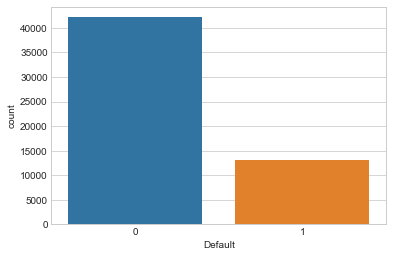

In [119]:
# lets have a look at Default proportion
sns.countplot(df["Default"])
plt.show()

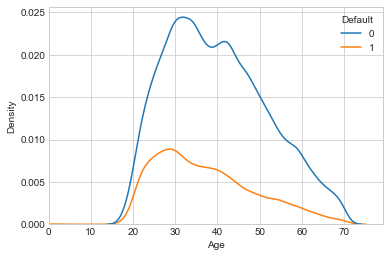

In [120]:
# let's visualize Default with respect to Age
sns.kdeplot(df.Age ,hue=df.Default)
plt.xlim(left=0)
plt.show()

### Non-private logistic regression

<div class="alert alert-block alert-info">
    <b>Embedding noise into data</b>
</div>

In [236]:
num_cols = list(df.select_dtypes(include='float'))
num_cols

['AppliedAmount',
 'DebtToIncome',
 'ExpectedLoss',
 'LiabilitiesTotal',
 'FreeCash',
 'Interest',
 'LossGivenDefault',
 'MonthlyPayment',
 'ProbabilityOfDefault',
 'Income_all_Total']

In [123]:
continuous_features = df[['Age', 
              'AppliedAmount',
              'DebtToIncome',
              'ExpectedLoss',
              'LiabilitiesTotal',
              'FreeCash',
              'Interest',
              'LossGivenDefault',
              'MonthlyPayment',
              'ProbabilityOfDefault',
              'Income_all_Total']]

In [124]:
df2 = df.copy()

In [125]:
# function to embed noise into continuous features
def dp(x):
    senstivity =1
    epsilon = 0.1
    value = x + np.random.laplace(loc=0, scale=senstivity/epsilon)
    return value

In [126]:
# embed noise into continuous features
df2['Age'] = df2['Age'].apply(lambda x: dp(x))
df2['AppliedAmount'] = df2['AppliedAmount'].apply(lambda x: dp(x))
df2['DebtToIncome'] = df2['DebtToIncome'].apply(lambda x: dp(x))
df2['ExpectedLoss'] = df2['ExpectedLoss'].apply(lambda x: dp(x))
df2['LiabilitiesTotal'] = df2['LiabilitiesTotal'].apply(lambda x: dp(x))
df2['FreeCash'] = df2['FreeCash'].apply(lambda x: dp(x))
df2['Interest'] = df2['Interest'].apply(lambda x: dp(x))
df2['LossGivenDefault'] = df2['LossGivenDefault'].apply(lambda x: dp(x))
df2['MonthlyPayment'] = df2['MonthlyPayment'].apply(lambda x: dp(x))
df2['AProbabilityOfDefaultge'] = df2['ProbabilityOfDefault'].apply(lambda x: dp(x))
df2['Income_all_Total'] = df2['Income_all_Total'].apply(lambda x: dp(x))

In [130]:
df2.DebtToIncome.describe()

count    55353.000000
mean         9.262174
std         22.288717
min       -106.199689
25%         -4.007660
50%          4.105898
75%         19.714377
max        135.940529
Name: DebtToIncome, dtype: float64

In [129]:
df.DebtToIncome.describe()

count    55353.000000
mean         9.324133
std         17.303824
min          0.000000
25%          0.000000
50%          0.000000
75%         12.160000
max         75.610000
Name: DebtToIncome, dtype: float64

<div class="alert alert-block alert-info">
<b>Model</b>
    Now, let's train a Logistic Regression classifier. 
</div>

In [131]:
X = df2.drop(['Default'], axis=1)
y = df2['Default']

In [132]:
from sklearn.linear_model import LogisticRegression
import diffprivlib.models as dp
#from diffprivlib.models import LogisticRegression
#from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,f1_score, recall_score, precision_score, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.datasets import make_classification


In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [158]:
# Normalization If scaler is used before train_test_split, data leakage will happen. 
# Do use scaler after train_test_split
MM  = MinMaxScaler()
X_train = MM.fit_transform(X_train)
X_test = MM.fit_transform(X_test)

In [243]:
# Fit the Simple Logistic Regression model and get the predictions
lr = LogisticRegression(random_state=5, class_weight='balanced')
model_fit = lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_p_lr = lr.predict_proba(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

In [245]:
f1_lr = f1_score(y_test, y_pred_lr)
recal_lr = recall_score(y_test,y_pred_lr )
precision_lr=precision_score(y_test, y_pred_lr)

In [246]:
f1_lr, recal_lr, precision_lr

(0.38805087252292225, 0.3321518987341772, 0.4665718349928876)

In [247]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84     12656
           1       0.47      0.33      0.39      3950

    accuracy                           0.75     16606
   macro avg       0.64      0.61      0.62     16606
weighted avg       0.73      0.75      0.74     16606



In [168]:
baseline = lr.score(X_test, y_test)
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

Non-private test accuracy: 75.08%


#### Let's check the predictions of cust customer running the model with different index

In [252]:
cust = 22 #the index of the row
lr = LogisticRegression(random_state=5, class_weight='balanced')
lr.fit(X_train, y_train)
pred_lr22 = lr.predict(np.array(X_test[cust,:]).reshape(1, -1))
pred_p_lr22 = lr.predict_proba(np.array(X_test[cust,:]).reshape(1, -1))[:, 0]
#accuracy_lr22 = accuracy_score(np.array(y_test[cust,:], pred_lr22)

In [254]:
pred_lr22, pred_p_lr22

(array([0], dtype=int64), array([0.76190689]))

In [255]:
cust = 8888 #the index of the row
lr = LogisticRegression(random_state=5, class_weight='balanced')
lr.fit(X_train, y_train)
pred_lr888 = lr.predict(np.array(X_test[cust,:]).reshape(1, -1))
pred_p_lr888 = lr.predict_proba(np.array(X_test[cust,:]).reshape(1, -1))[:, 0]
#accuracy_lr22 = accuracy_score(y_test, pred_lr22)

In [256]:
pred_lr888, pred_p_lr888

(array([1], dtype=int64), array([0.42080434]))

<div class="alert alert-block alert-success">
<b>Inference:</b>
    Simple Logistic Regression predicts the same outcome for the same customer if we run the model multiple times
</div>

### Differentially private logistic regression


<div class="alert alert-block alert-info">
<b>DP Model</b>
    Now, let's train a differentially private Logistic Regression classifier. Our classifier runs just like an sklearn classifier.    
    diffprivlib.models.LogisticRegression can be run without any parameters, although this will throw a warning (we need to specify the bounds parameter to avoid this). The privacy level is controlled by the parameter epsilon, which is passed to the classifier at initialisation (e.g. LogisticRegression(epsilon=0.1)). The default is epsilon = 1.0
</div>

In [129]:
#accuracy_score(y_test, np.array(y_dp_pred))

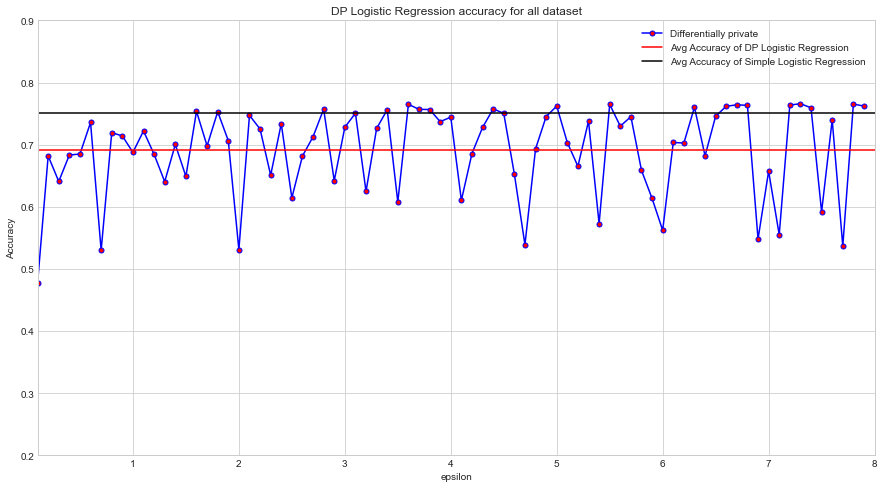

79

In [275]:
# DP model on full dataset
from numpy import arange
from sklearn.metrics import accuracy_score

epsilons = arange(0.1, 8, 0.1)
y_dp_pred_full = list()
y_dp_pred_p = list()
y_accuracy_dp = list()
#y_conf_matrix_dp = list()

for epsilon in epsilons:
    dp_clf = dp.LogisticRegression(epsilon=epsilon, data_norm=100)
    dp_clf.fit(X_train, y_train)
    y_dp_pred = dp_clf.predict(X_test)
    y_dp_pred_full.append(dp_clf.predict(X_test))
    #y_dp_pred.append(dp_clf.predict(X_test))
    y_dp_pred_p.append(dp_clf.predict_proba(X_test))
    y_accuracy_dp.append(accuracy_score(y_test, y_dp_pred))
    
#y_zipped = list(zip(epsilons, y_dp_pred, y_dp_pred_p, y_accuracy_dp))
#y_result_table = pd.DataFrame(y_zipped, columns=['epsilons', 'dp_pred', 'dp_pred_p', 'accuracy_dp'])
#result_table.set_index('epsilons', inplace=True)
y_average_accuracy = np.array(y_accuracy_dp).mean() 
# y_dp_pred_p_mean = np.array(y_dp_pred_p).mean() 

y_average_accuracy = np.array(y_accuracy_dp).mean() 
y_dp_pred_p_mean = np.array(y_dp_pred_p).mean() 

plt.figure(figsize=(15,8))
plt.plot(epsilons, y_accuracy_dp, label="Differentially private", color='blue', marker= 'o', markerfacecolor = 'red', markersize = 5)
plt.axhline(y =y_average_accuracy, color ='red', label ='Avg Accuracy of DP Logistic Regression')
plt.axhline(y =baseline, color ='black', label ='Avg Accuracy of Simple Logistic Regression')
#plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private")
plt.title("DP Logistic Regression accuracy for all dataset")
plt.ylim(0.20, 0.90)
plt.xlim(0.1, 8)
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
len(epsilons)

In [260]:
# Accuracy for full dataset
max(y_accuracy_dp), min(y_accuracy_dp), y_average_accuracy, baseline

(0.7663495122244972,
 0.4269541129712152,
 0.6882368276221649,
 0.7508129591713838)

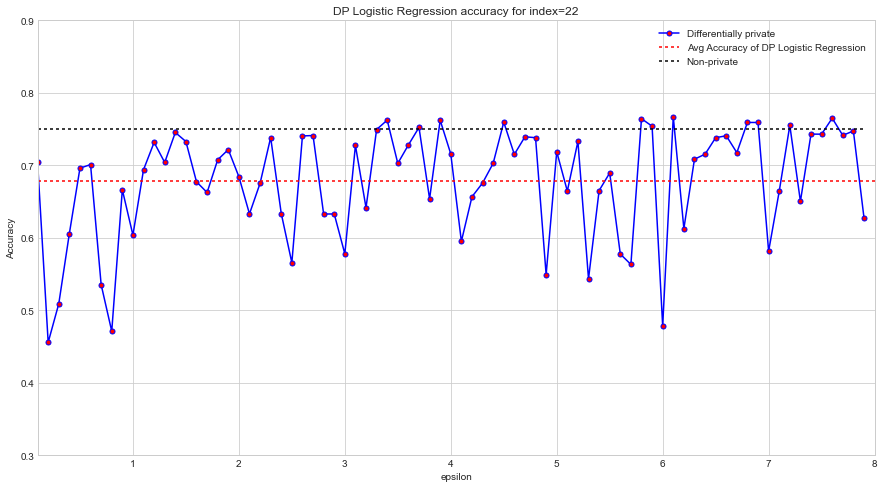

79

In [273]:
#DP modelling for cust (= int(input('Enter the index '))
from numpy import arange
import warnings
warnings.filterwarnings('ignore')
cust = 22
epsilons = arange(0.1, 8, 0.1)
dp_pred = list()
dp_pred_p = list()
accuracy_dp = list()
conf_matrix_dp = list()

for epsilon in epsilons:
    dp_clf = dp.LogisticRegression(epsilon=epsilon, data_norm=100)
    dp_clf.fit(X_train, y_train)
    dp_pred.append(dp_clf.predict(np.array(X_test[cust,:]).reshape(1, -1)))
    dp_pred_p.append(dp_clf.predict_proba(np.array(X_test[cust,:]).reshape(1, -1))[:, 1])
    accuracy_dp.append(dp_clf.score(X_test, y_test))
zipped = list(zip(epsilons, dp_pred, dp_pred_p, accuracy_dp))
result_table = pd.DataFrame(zipped, columns=['epsilons', 'dp_pred', 'dp_pred_p', 'accuracy_dp'])
#result_table.set_index('epsilons', inplace=True)
average_accuracy = np.array(accuracy_dp).mean() 
dp_pred_p_mean = np.array(dp_pred_p).mean() 
plt.figure(figsize=(15,8))
plt.plot(epsilons, accuracy_dp, label="Differentially private", color='blue', marker= 'o', markerfacecolor = 'red', markersize = 5)
plt.axhline(y =average_accuracy, color ='red',dashes=[2,2], label ='Avg Accuracy of DP Logistic Regression')

plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], color ='black', label="Non-private")
plt.title("DP Logistic Regression accuracy for index=22")
plt.ylim(0.30, 0.90)
plt.xlim(0.1,8)
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
len(epsilons)

In [262]:
# Acccuracy for one customer ubder index 22
max(accuracy_dp), min(accuracy_dp), average_accuracy, baseline

(0.7673130193905817,
 0.4937974226183307,
 0.6971492689084469,
 0.7508129591713838)

In [118]:
best_accuracy = result_table.sort_values(by = ['accuracy_dp'], ascending=False).head(10)

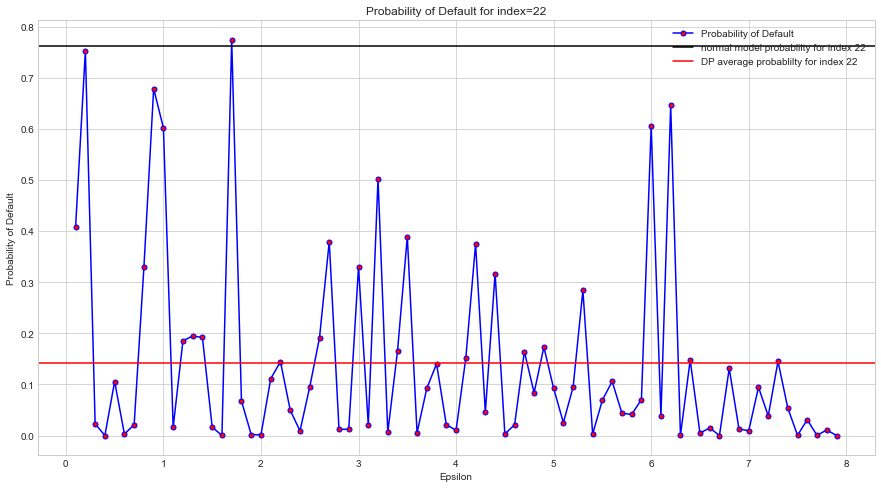

In [277]:
plt.figure(figsize=(15, 8))
plt.plot(epsilons, dp_pred_p, color='blue', marker= 'o', markerfacecolor = 'red', markersize = 5, label='Probability of Default')
plt.axhline(y=pred_p_lr22, color ='black', label= 'normal model probablilty for index 22')
plt.axhline(y=dp_pred_p_mean, color ='red', label= 'DP average probablilty for index 22')

plt.title("Probability of Default for index=22")
plt.xlabel("Epsilon")
plt.ylabel("Probability of Default")
plt.legend()
plt.show()

In [278]:
pred_p_lr22, dp_pred_p_mean, dp_pred.count(0), dp_pred.count(1)

(array([0.76190689]), 0.1419086352569887, 72, 7)

On the chart above we see that DP model predicted 79 times "0" and 0 times "1", wereas simple model predicted "1"(taking into account that treshold >0.5)

<div class="alert alert-block alert-success">
<b>Inference:</b>
   DP Logistic Regression predicts different customer default value for the same index with changed epsilon
</div>

In [62]:

f1 =[]
recall =[]
precision =[]
pred_prob=[]

for epsilon in epsilons:
    dp_clf = dp.LogisticRegression(epsilon=epsilon, data_norm=100)
    dp_clf.fit(X_train, y_train)
    prediction_test=dp_clf.predict(X_test)
    
    f1.append(f1_score(y_test, prediction_test, average ='binary'))
    recall.append(recall_score(y_test, prediction_test, average ='binary'))
    precision.append(precision_score(y_test, prediction_test, average ='binary'))
    pred_prob.append(dp_clf.predict_proba(X_test)[:,0])

In [63]:
f1avg = np.average(f1)
precisionavg =np.average(precision)
recallavg=np.average(recall)

In [64]:
f1avg, precisionavg, recallavg

(0.24921194219562348, 0.3357484816794315, 0.27865406184906266)

The highest possible value of an F-score is 1.0, indicating perfect precision and recall, and the lowest possible value is 0, if either the precision or the recall is zero.

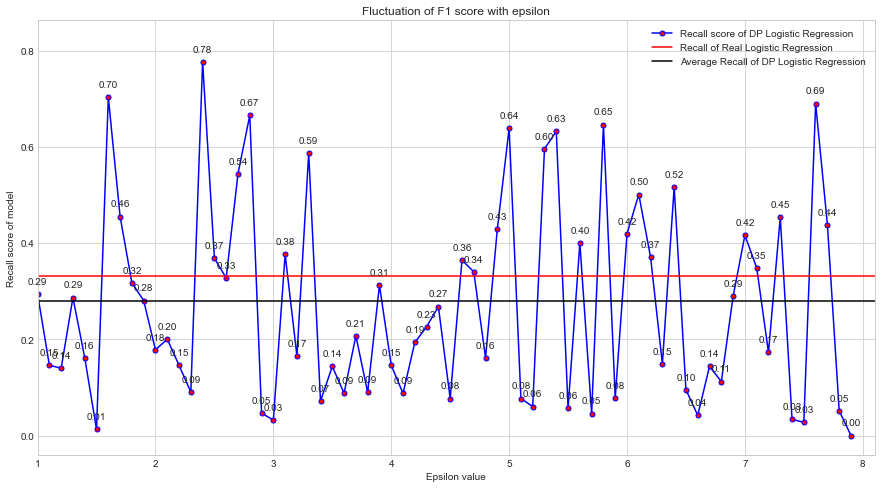

In [279]:
plt.figure(figsize=(15,8))
plt.plot(epsilons, recall, color ='blue', 
         marker= 'o', markerfacecolor = 'red', markersize = 5, label = 'Recall score of DP Logistic Regression')

plt.axhline(y=recal_lr, color ='red', label= 'Recall of Real Logistic Regression')
plt.axhline(y =recallavg, color ='black', label ='Average Recall of DP Logistic Regression')
# plt.ylim(0, 0.9)
plt.xlim(1,8.1)
plt.xlabel('Epsilon value')
plt.ylabel('Recall score of model')
plt.title('Fluctuation of F1 score with epsilon')
plt.legend()
for x,y in zip(epsilons,recall):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
plt.show()

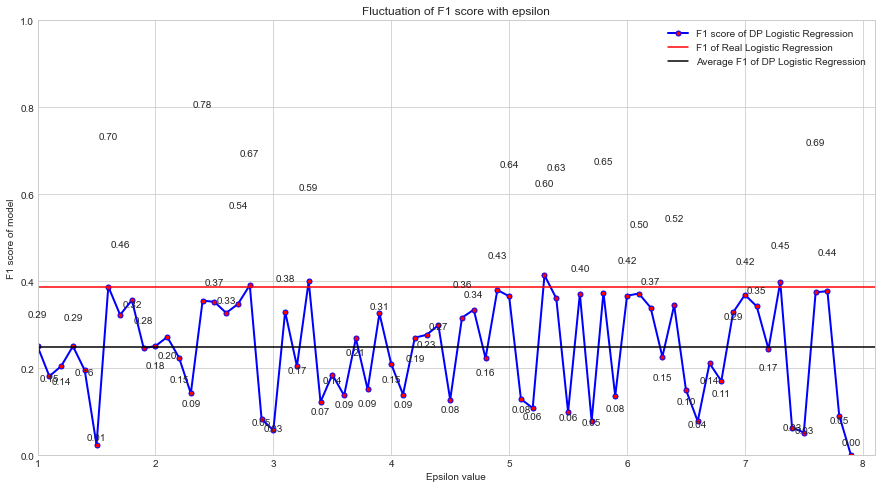

In [214]:
plt.figure(figsize=(15,8))
plt.plot(epsilons, f1, color ='blue', linewidth = 2,
         marker= 'o', markerfacecolor = 'red', markersize = 5, label = 'F1 score of DP Logistic Regression')

plt.axhline(y=f1_lr, color ='red', label= 'F1 of Real Logistic Regression')
plt.axhline(y =f1avg, color ='black', label ='Average F1 of DP Logistic Regression')
plt.ylim(0, 1)
plt.xlim(1,8.1)
plt.xlabel('Epsilon value')
plt.ylabel('F1 score of model')
plt.title('Fluctuation of F1 score with epsilon')
plt.legend()
for x,y in zip(epsilons,recall):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
plt.show()

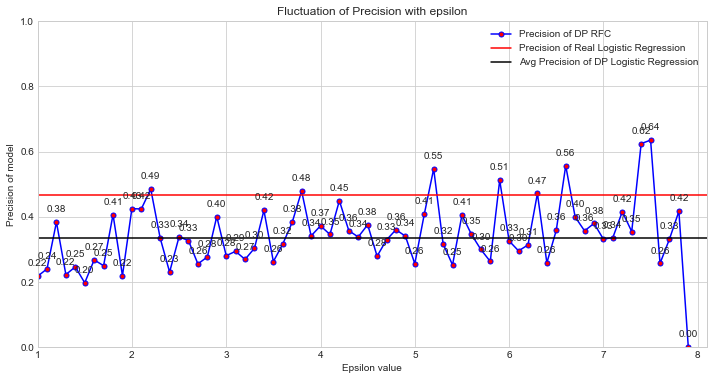

In [280]:
plt.figure(figsize=(12,6))
#x= arange(0.1,8.0, 0.1)
plt.plot(epsilons, precision, color ='blue', marker= 'o', markerfacecolor = 'red', markersize = 5, label = 'Precision of DP RFC')
#plt.style.use('seaborn-whitegrid')

plt.axhline(y=precision_lr, color ='red', label= 'Precision of Real Logistic Regression')
plt.axhline(y =precisionavg, color ='black', label ='Avg Precision of DP Logistic Regression')
plt.ylim(0, 1)
plt.xlim(1,8.1)
plt.xlabel('Epsilon value')
plt.ylabel('Precision of model')
plt.title('Fluctuation of Precision with epsilon')
plt.legend()
for x,y in zip(epsilons,precision):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
plt.show()

In [281]:
average_accuracy_dp22 = np.array(accuracy_dp_range).mean() 
dp_pred_p_mean22 = np.array(dp_pred_p_range).mean()
average_accuracy_dp22, dp_pred_p_mean22

(0.6636185716006263, 0.7867389157867182)

<div class="alert alert-block alert-info">
<b>Iterating the DP model multiple times with the same epsilon</b>
</div>

In [290]:
import warnings
warnings.filterwarnings('ignore')
cust = 22
dp_pred_range = list()
accuracy_dp_range = list()
dp_pred_p_range = list()
#epsilons = arange(0.1, 4.0, 0.1)
conf_matrix_dp = list()

for i in range(0, 20):
    dp_clf = dp.LogisticRegression(epsilon=2, data_norm=100)
    dp_clf.fit(X_train, y_train)
    dp_pred_range.append(dp_clf.predict((np.array(X_test[cust,:])).reshape(1, -1)))
    dp_pred_p_range.append(dp_clf.predict_proba((np.array(X_test[cust,:])).reshape(1, -1))[:, 1])
    accuracy_dp_range.append(dp_clf.score(X_test, y_test))
    dp_pred_p_mean22 = np.array(dp_pred_p_range).mean()

In [291]:
dp_pred_p_mean22

0.23984641099815596

In [292]:
pred_p_lr22, dp_pred_range.count(0), dp_pred_range.count(1)

(array([0.76190689]), 17, 3)

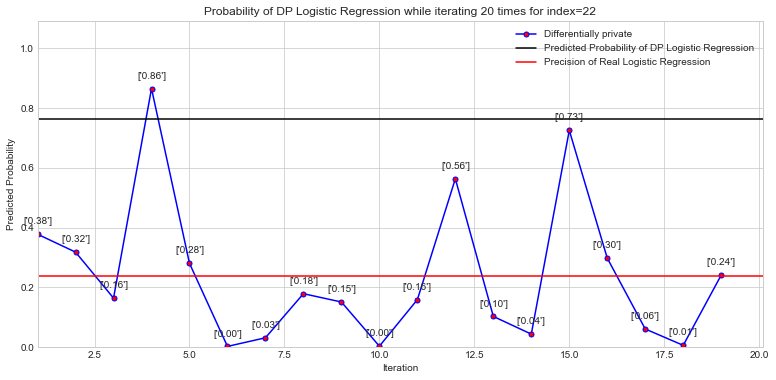

In [294]:
plt.figure(figsize=(13,6))
x_axis = range(0,20)
plt.plot(x_axis, dp_pred_p_range, color ='blue', marker= 'o', markerfacecolor = 'red', markersize = 5, label="Differentially private")
plt.axhline(y =pred_p_lr22, color ='black', label ='Predicted Probability of DP Logistic Regression')
plt.axhline(y=dp_pred_p_mean22, color ='red', label= 'Precision of Real Logistic Regression')

#plt.plot(range(0,20), np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private")
plt.title("Probability of DP Logistic Regression while iterating 20 times for index=22")
plt.ylim(0.0, 1.09)
plt.xlim(1,20.1)
plt.xlabel("Iteration")
plt.ylabel("Predicted Probability")
plt.legend()
for x,y in zip(x_axis,dp_pred_p_range):
    label = list(map("{:.2f}".format,y))
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
plt.show()


In [295]:
import warnings
warnings.filterwarnings('ignore')
cust = 8888
dp_pred_range = list()
accuracy_dp_range = list()
dp_pred_p_range = list()
#epsilons = arange(0.1, 4.0, 0.1)
conf_matrix_dp = list()

for i in range(0, 20):
    dp_clf = dp.LogisticRegression(epsilon=2, data_norm=100)
    dp_clf.fit(X_train, y_train)
    dp_pred_range.append(dp_clf.predict((np.array(X_test[cust,:])).reshape(1, -1)))
    dp_pred_p_range.append(dp_clf.predict_proba((np.array(X_test[cust,:])).reshape(1, -1))[:, 0])
    accuracy_dp_range.append(dp_clf.score(X_test, y_test))

In [296]:
average_accuracy_dp888 = np.array(accuracy_dp_range).mean() 
dp_pred_p_mean888 = np.array(dp_pred_p_range).mean()
average_accuracy_dp888, dp_pred_p_mean22

(0.6881428399373721, 0.23984641099815596)

In [297]:
pred_p_lr888, dp_pred_range.count(0), dp_pred_range.count(1)

(array([0.42080434]), 13, 7)

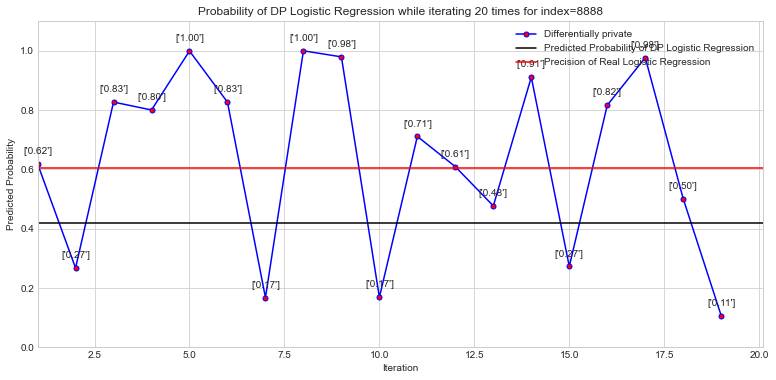

In [298]:
plt.figure(figsize=(13,6))
plt.plot(range(0,20), dp_pred_p_range, color ='blue', marker= 'o', markerfacecolor = 'red', markersize = 5, label="Differentially private")
plt.axhline(y =pred_p_lr888, color ='black', label ='Predicted Probability of DP Logistic Regression')
plt.axhline(y=dp_pred_p_mean888, color ='red', label= 'Precision of Real Logistic Regression')

#plt.plot(range(0,20), np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private")
plt.title("Probability of DP Logistic Regression while iterating 20 times for index=8888")
plt.ylim(0.0, 1.1)
plt.xlim(1,20.1)
plt.xlabel("Iteration")
plt.ylabel("Predicted Probability")
plt.legend()
for x,y in zip(x_axis,dp_pred_p_range):
    label = list(map("{:.2f}".format,y))
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')

In [310]:
pred_p2=[]
for i in range(0,20):
    pred_p2.append(dp_clf.predict_proba((np.array(X_test[cust,:])).reshape(1,-1))[:,0])

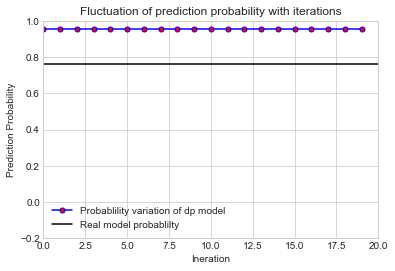

In [324]:
#line graph Dp_proba Vs Real_proba
plt.figure(figsize=(13,6))
plt.plot(range(0,20), pred_p2,color ='blue', marker= 'o', markerfacecolor = 'red', markersize = 5,label ='Probablility variation of dp model')
plt.style.use('seaborn-whitegrid')
plt.ylim(-0.2, 1.0)
plt.xlim(0,20)
plt.axhline(y=pred_p_lr22, color ='black', label= 'Real model probablilty')
plt.xlabel('Ineration')
plt.ylabel('Prediction Probability')
plt.title('Fluctuation of prediction probability with iterations')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
<b>Let's check how many times DP model predicts Default and Non Default out of 79 epsilons ranging from 0.1 to 8</b>
</div>

In [330]:
cust = 2 #the index of the row
lr = LogisticRegression(random_state=5, class_weight='balanced')
lr.fit(X_train, y_train)
pred_lr2 = lr.predict(np.array(X_test[cust,:]).reshape(1, -1))
pred_p_lr2 = lr.predict_proba(np.array(X_test[cust,:]).reshape(1, -1))[:, 0]
#accuracy_lr22 = accuracy_score(np.array(y_test[cust,:], pred_lr22)

In [344]:
cust = 2
dp_pred2 = list()
accuracy_dp2 = list()
dp_pred_p2 = list()
epsilons = arange(0.1, 8.0, 0.2)
conf_matrix_dp = list()

for epsilon in epsilons:
    dp_clf = dp.LogisticRegression(epsilon=epsilon, data_norm=100)
    dp_clf.fit(X_train, y_train)
    #dp_clf.coef_[0, 1]
    dp_pred2.append(dp_clf.predict(X_test[cust,:].reshape(1, -1)))
    dp_pred_p2.append(dp_clf.predict_proba(X_test[cust,:].reshape(1, -1))[:, 1])
    accuracy_dp2.append(dp_clf.score(X_test, y_test)),
    average_accuracy_dp2 = np.array(accuracy_dp2).mean() 

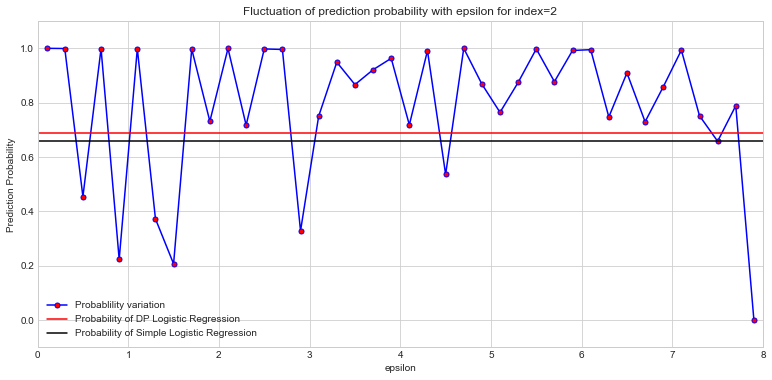

In [333]:
#line graph plotted Dp_proba fluctuatting with different epsilon for cust =2
plt.figure(figsize=(13,6))
plt.plot(epsilons, dp_pred_p,color ='blue', marker= 'o', markerfacecolor = 'red', markersize = 5,label ='Probablility variation')
plt.axhline(y=average_accuracy_dp2, color ='red', label= 'Probability of DP Logistic Regression')
plt.axhline(y=pred_p_lr2, color ='black', label= 'Probability of Simple Logistic Regression')

plt.ylim(-0.1, 1.1)
plt.xlim(0,8)
plt.xlabel('epsilon')
plt.ylabel('Prediction Probability')
plt.title('Fluctuation of prediction probability with epsilon for index=2')
plt.legend()
plt.show()

In [338]:
pred_p_lr2, dp_pred_p2.count(0), dp_pred_p2.count(1)

(array([0.65843168]), 0, 2)

In [343]:
 dp_pred_p
    

[array([1.]),
 array([0.99928015]),
 array([0.45428784]),
 array([0.99886768]),
 array([0.2234815]),
 array([0.99880805]),
 array([0.37258309]),
 array([0.20703108]),
 array([0.99731639]),
 array([0.73147344]),
 array([0.99952658]),
 array([0.71725555]),
 array([0.99770094]),
 array([0.99582243]),
 array([0.32830971]),
 array([0.75029147]),
 array([0.94897513]),
 array([0.86648948]),
 array([0.92120616]),
 array([0.96318845]),
 array([0.71825945]),
 array([0.99139861]),
 array([0.53624499]),
 array([0.99999257]),
 array([0.86840258]),
 array([0.76437383]),
 array([0.87449482]),
 array([0.99785134]),
 array([0.87739236]),
 array([0.99207709]),
 array([0.99501871]),
 array([0.74732955]),
 array([0.90965343]),
 array([0.72974973]),
 array([0.85811062]),
 array([0.99319925]),
 array([0.75182676]),
 array([0.65800542]),
 array([0.78874602]),
 array([0.])]

<div class="alert alert-block alert-info">
<b>roc_curve,roc_auc_score</b>
</div>

In [345]:
from sklearn.metrics import roc_curve,roc_auc_score

In [346]:
dp_pred_p = []
roc_auc_table = pd.DataFrame()
for i in arange(0.1, 4.0, 0.1):
    dp_clf = dp.LogisticRegression(epsilon=i, data_norm=100)
    dp_clf.fit(X_train, y_train)
    #dp_pred.append(dp_clf.predict(X_test[::,1]))
    dp_pred_p = dp_clf.predict_proba(X_test)[::,1]
    #dp_pred_p = dp_clf.predict_proba(np.array(X_test.iloc[cust,:]).reshape(1, -1))[:,1]
    #accuracy_dp.append(dp_clf.score(X_test, y_test))
    fpr, tpr, _ = roc_curve(y_test,  dp_pred_p)
    auc = roc_auc_score(y_test, dp_pred_p)
    
#     roc_auc_table = roc_auc_table.append({'epsilons':epsilons,
#                                         'fpr':fpr, 
#                                         'tpr':tpr, 
#                                         'auc':auc}, ignore_index=True)
# #result_table.set_index('epsilons', inplace=True) 


In [348]:
len(dp_pred_p)

16606

In [349]:
for i in  dp_pred_p:
    fpr, tpr, _ = roc_curve(y_test,  dp_pred_p)
    auc = roc_auc_score(y_test, dp_pred_p)
    
    roc_auc_table = roc_auc_table.append({'epsilons':epsilons,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
#result_table.set_index('epsilons', inplace=True)    

In [302]:
roc_auc_table

,auc,epsilons,fpr,tpr
0,0.54593,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,...","[0.0, 7.901390644753477e-05, 0.000711125158027...","[0.0, 0.0, 0.0, 0.00025316455696202533, 0.0002..."
1,0.54593,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,...","[0.0, 7.901390644753477e-05, 0.000711125158027...","[0.0, 0.0, 0.0, 0.00025316455696202533, 0.0002..."
2,0.54593,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,...","[0.0, 7.901390644753477e-05, 0.000711125158027...","[0.0, 0.0, 0.0, 0.00025316455696202533, 0.0002..."
3,0.54593,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,...","[0.0, 7.901390644753477e-05, 0.000711125158027...","[0.0, 0.0, 0.0, 0.00025316455696202533, 0.0002..."
4,0.54593,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,...","[0.0, 7.901390644753477e-05, 0.000711125158027...","[0.0, 0.0, 0.0, 0.00025316455696202533, 0.0002..."
...,...,...,...,...
16601,0.54593,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,...","[0.0, 7.901390644753477e-05, 0.000711125158027...","[0.0, 0.0, 0.0, 0.00025316455696202533, 0.0002..."
16602,0.54593,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,...","[0.0, 7.901390644753477e-05, 0.000711125158027...","[0.0, 0.0, 0.0, 0.00025316455696202533, 0.0002..."
16603,0.54593,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,...","[0.0, 7.901390644753477e-05, 0.000711125158027...","[0.0, 0.0, 0.0, 0.00025316455696202533, 0.0002..."
16604,0.54593,"[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,...","[0.0, 7.901390644753477e-05, 0.000711125158027...","[0.0, 0.0, 0.0, 0.00025316455696202533, 0.0002..."


In [354]:
fig = plt.figure(figsize=(15,15))

for i in roc_auc_table.index:
    plt.plot(roc_auc_table.loc[i]['fpr'], 
             roc_auc_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, roc_auc_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()
# def plot_roc_curve(fpr,tpr, v=str()): 
#     #plt.figure(figsize=(6,6))
#     plt.plot(fpr,tpr, color='orange', linestyle='--') 
#     plt.axis([0,1,0,1]) 
#     plt.xlabel('False Positive Rate') 
#     plt.ylabel('True Positive Rate') 
#     plt.title(v)
#     plt.show()    
# # fpr , tpr , thresholds = roc_curve ( y_test, y_pred_p_lr)
# # plot_roc_curve(fpr, tpr, "Simple Logistic Regression") 

# plt.show()

ValueError: Image size of 886x308926 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1080x1080 with 1 Axes>

In [351]:

fpr , tpr , thresholds = roc_curve( y_test, pred_prob[0])

In [352]:
pred_prob[49]

array([3.00467547e-04, 4.80782801e-01, 1.88137807e-01, ...,
       4.58409618e-02, 3.11776202e-01, 8.61001687e-01])

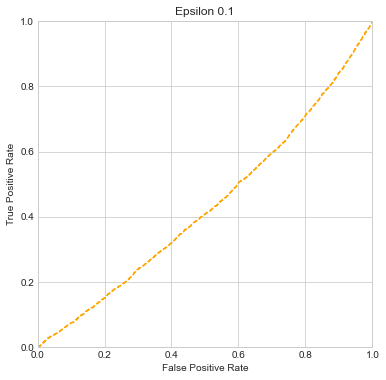

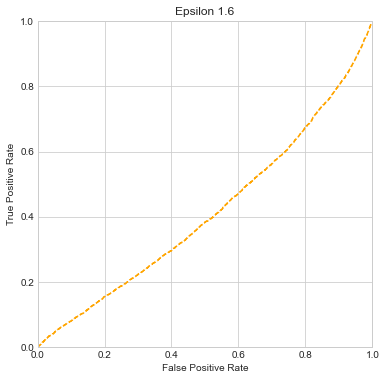

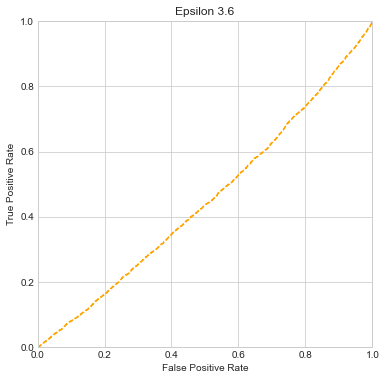

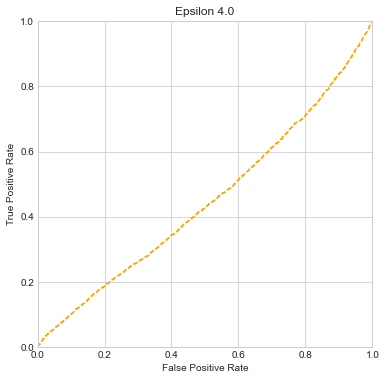

In [308]:
def plot_roc_curve(fpr,tpr, v=str()): 
    plt.figure(figsize=(6,6))
    plt.plot(fpr,tpr, color='orange', linestyle='--') 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title(v)
    plt.show()    
# fpr , tpr , thresholds = roc_curve ( y_test, y_pred_p_lr)
# plot_roc_curve(fpr, tpr, "Simple Logistic Regression")   
fpr , tpr , thresholds = roc_curve( y_test, pred_prob[0])  
plot_roc_curve(fpr, tpr, "Epsilon 0.1")
fpr , tpr , thresholds = roc_curve ( y_test, pred_prob[15])
plot_roc_curve(fpr, tpr, "Epsilon 1.6")
fpr , tpr , thresholds = roc_curve ( y_test, pred_prob[35])
plot_roc_curve(fpr, tpr, "Epsilon 3.6")
fpr , tpr , thresholds = roc_curve ( y_test, pred_prob[49])
plot_roc_curve(fpr, tpr, "Epsilon 4.0")

In [309]:
f1avg = np.average(f1)
precisionavg =np.average(precision)
recallavg=np.average(recall)

<div class="alert alert-block alert-info">

</div>